# AutoEncoder 설계
특정 클래스 분류를 하는 것이 아니라 우너본 데이터를 생성하는 AutoEncoder를 만들어보자

# 전처리

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [3]:
BATCH_SIZE = 128
EPOCHS = 15

- transform
  - 데이터를 다운로드 할 때 데이터에 대한 기본 전처리는 가능하다.
  - AE 모델을 비롯한 인공 신경망 모델은 학습시 input 데이터 값의 크기가 커질수록 불안정하거나 과적합되는 방향으로 진행될 우려가 있기 때문에 정규화를 통해 input을 바꿔줘야 한다.

In [4]:
train_dataset = datasets.FashionMNIST(root='./', download=True, train=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
for (X_train, y_train) in train_loader:
  print('X_train : ', X_train.size(), 'type : ', X_train.type())
  print('y_train : ', y_train.size(), 'type : ', y_train.type())
  break

X_train :  torch.Size([128, 1, 28, 28]) type :  torch.FloatTensor
y_train :  torch.Size([128]) type :  torch.LongTensor


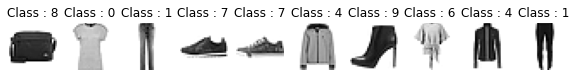

In [6]:
pltsize = 1
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
  plt.title('Class : '+str(y_train[i].item()))

# AutoEncoder 설계

In [7]:
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28*28),
    )


  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [8]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss() # 여기선 MSE를 쓰네

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [9]:
# train 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, _) in enumerate(train_loader):
    # image와 target이 같다.
    image = image.view(-1, 28*28).to(DEVICE)
    target = image.view(-1, 28*28).to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded = model(image)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss : {:.6f}'.format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item()))

In [10]:
# evaluate 함수 정의
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  real_image = []
  gen_image = []
  with torch.no_grad(): # 모델 평가하는 과정중에 gradient가 업데이트 되는 걸 방지하기 멈춰두기
    for image, _ in test_loader: # test_loader에서 image만 불러오기
      image = image.view(-1, 28*28).to(DEVICE)
      target = image.view(-1, 28*28).to(DEVICE)
      encoded, decoded = model(image)

      # loss 평균을 내기위해 일단 다 더해주고 마지막에서 크기로 나워서 평균 구함
      test_loss += criterion(decoded, image).item() # item() : torch tensor에서 변수값만 가져오는 함수 
      # image tensor를 cpu로 보내고 리스트에 값들 append해주기
      real_image.append(image.to('cpu'))
      # decoded를 통해 만들어진 이미지 텐서 리스트 생성
      gen_image.append(decoded.to('cpu'))

  test_loss /= len(test_loader.dataset)
  return test_loss, real_image, gen_image

# 학습 시작과 평가

In [11]:
from tqdm import tqdm

  0%|          | 0/15 [00:00<?, ?it/s]


Train Epoch: 1 [0/60000(0%)] 	 Train Loss : 0.209208
Train Epoch: 1 [25600/60000(43%)] 	 Train Loss : 0.025986
Train Epoch: 1 [51200/60000(85%)] 	 Train Loss : 0.020934

[EPOCH : 1], 	 Test Loss : 0.0002


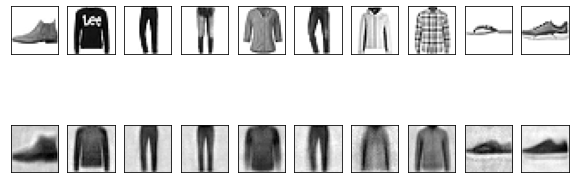

  7%|▋         | 1/15 [00:09<02:10,  9.30s/it]


Train Epoch: 2 [0/60000(0%)] 	 Train Loss : 0.019833
Train Epoch: 2 [25600/60000(43%)] 	 Train Loss : 0.016837
Train Epoch: 2 [51200/60000(85%)] 	 Train Loss : 0.015374

[EPOCH : 2], 	 Test Loss : 0.0001


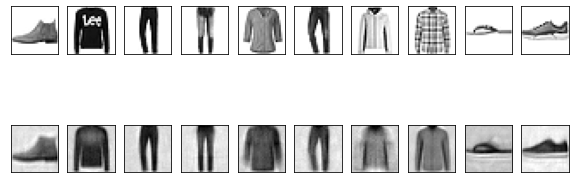

 13%|█▎        | 2/15 [00:17<01:48,  8.36s/it]


Train Epoch: 3 [0/60000(0%)] 	 Train Loss : 0.015649
Train Epoch: 3 [25600/60000(43%)] 	 Train Loss : 0.015449
Train Epoch: 3 [51200/60000(85%)] 	 Train Loss : 0.014405

[EPOCH : 3], 	 Test Loss : 0.0001


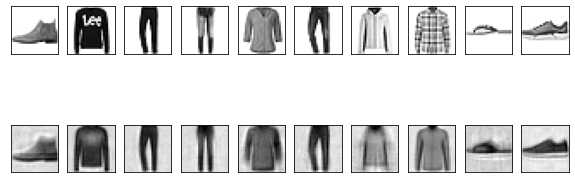

 20%|██        | 3/15 [00:24<01:33,  7.81s/it]


Train Epoch: 4 [0/60000(0%)] 	 Train Loss : 0.013843
Train Epoch: 4 [25600/60000(43%)] 	 Train Loss : 0.014123
Train Epoch: 4 [51200/60000(85%)] 	 Train Loss : 0.011141

[EPOCH : 4], 	 Test Loss : 0.0001


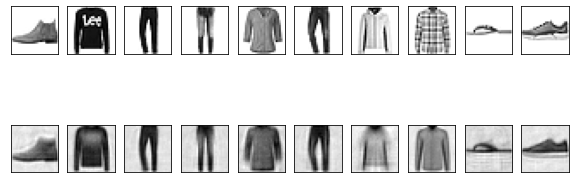

 27%|██▋       | 4/15 [00:30<01:21,  7.41s/it]


Train Epoch: 5 [0/60000(0%)] 	 Train Loss : 0.012786
Train Epoch: 5 [25600/60000(43%)] 	 Train Loss : 0.012899
Train Epoch: 5 [51200/60000(85%)] 	 Train Loss : 0.012938

[EPOCH : 5], 	 Test Loss : 0.0001


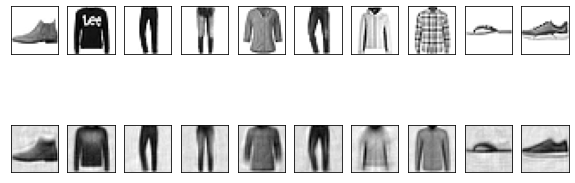

 33%|███▎      | 5/15 [00:38<01:13,  7.33s/it]


Train Epoch: 6 [0/60000(0%)] 	 Train Loss : 0.011495
Train Epoch: 6 [25600/60000(43%)] 	 Train Loss : 0.011759
Train Epoch: 6 [51200/60000(85%)] 	 Train Loss : 0.011992

[EPOCH : 6], 	 Test Loss : 0.0001


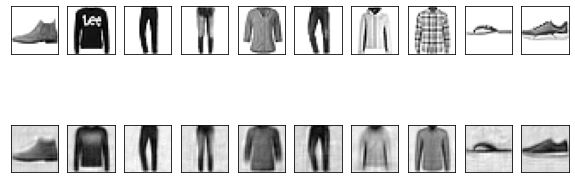

 40%|████      | 6/15 [00:45<01:07,  7.47s/it]


Train Epoch: 7 [0/60000(0%)] 	 Train Loss : 0.011634
Train Epoch: 7 [25600/60000(43%)] 	 Train Loss : 0.011061
Train Epoch: 7 [51200/60000(85%)] 	 Train Loss : 0.010884

[EPOCH : 7], 	 Test Loss : 0.0001


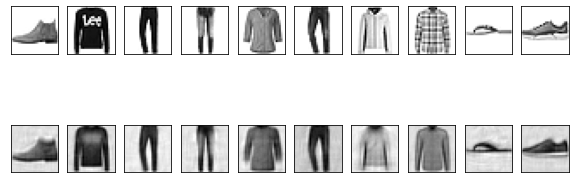

 47%|████▋     | 7/15 [00:53<00:59,  7.38s/it]


Train Epoch: 8 [0/60000(0%)] 	 Train Loss : 0.010916
Train Epoch: 8 [25600/60000(43%)] 	 Train Loss : 0.011060
Train Epoch: 8 [51200/60000(85%)] 	 Train Loss : 0.010003

[EPOCH : 8], 	 Test Loss : 0.0001


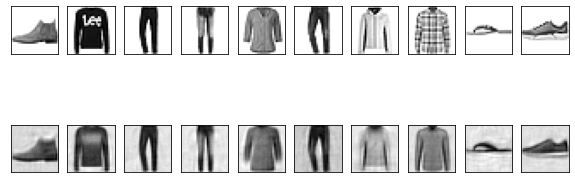

 53%|█████▎    | 8/15 [01:00<00:52,  7.44s/it]


Train Epoch: 9 [0/60000(0%)] 	 Train Loss : 0.010680
Train Epoch: 9 [25600/60000(43%)] 	 Train Loss : 0.010817
Train Epoch: 9 [51200/60000(85%)] 	 Train Loss : 0.010807

[EPOCH : 9], 	 Test Loss : 0.0001


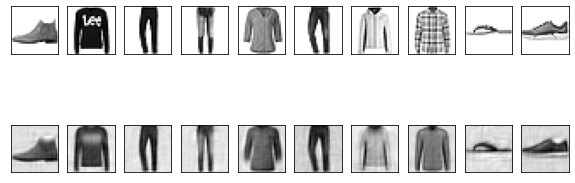

 60%|██████    | 9/15 [01:08<00:44,  7.45s/it]


Train Epoch: 10 [0/60000(0%)] 	 Train Loss : 0.010417
Train Epoch: 10 [25600/60000(43%)] 	 Train Loss : 0.008921
Train Epoch: 10 [51200/60000(85%)] 	 Train Loss : 0.009329

[EPOCH : 10], 	 Test Loss : 0.0001


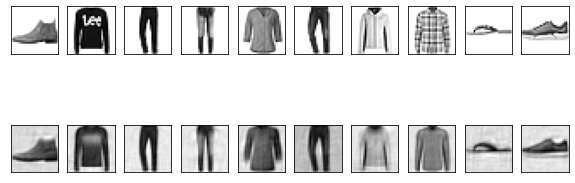

 67%|██████▋   | 10/15 [01:15<00:36,  7.32s/it]


Train Epoch: 11 [0/60000(0%)] 	 Train Loss : 0.010561
Train Epoch: 11 [25600/60000(43%)] 	 Train Loss : 0.010332
Train Epoch: 11 [51200/60000(85%)] 	 Train Loss : 0.010327

[EPOCH : 11], 	 Test Loss : 0.0001


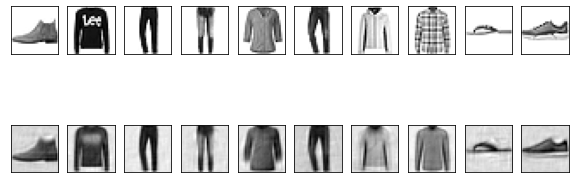

 73%|███████▎  | 11/15 [01:22<00:29,  7.28s/it]


Train Epoch: 12 [0/60000(0%)] 	 Train Loss : 0.010264
Train Epoch: 12 [25600/60000(43%)] 	 Train Loss : 0.010276
Train Epoch: 12 [51200/60000(85%)] 	 Train Loss : 0.010442

[EPOCH : 12], 	 Test Loss : 0.0001


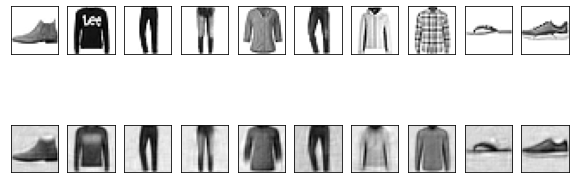

 80%|████████  | 12/15 [01:29<00:21,  7.18s/it]


Train Epoch: 13 [0/60000(0%)] 	 Train Loss : 0.009192
Train Epoch: 13 [25600/60000(43%)] 	 Train Loss : 0.010259
Train Epoch: 13 [51200/60000(85%)] 	 Train Loss : 0.009861

[EPOCH : 13], 	 Test Loss : 0.0001


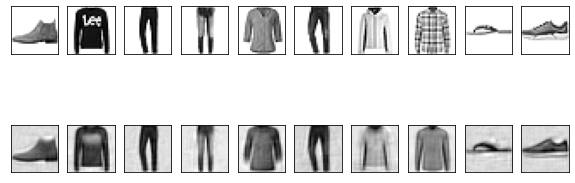

 87%|████████▋ | 13/15 [01:36<00:14,  7.14s/it]


Train Epoch: 14 [0/60000(0%)] 	 Train Loss : 0.010048
Train Epoch: 14 [25600/60000(43%)] 	 Train Loss : 0.008873
Train Epoch: 14 [51200/60000(85%)] 	 Train Loss : 0.010306

[EPOCH : 14], 	 Test Loss : 0.0001


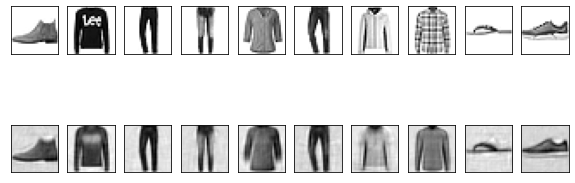

 93%|█████████▎| 14/15 [01:43<00:07,  7.07s/it]


Train Epoch: 15 [0/60000(0%)] 	 Train Loss : 0.009771
Train Epoch: 15 [25600/60000(43%)] 	 Train Loss : 0.009886
Train Epoch: 15 [51200/60000(85%)] 	 Train Loss : 0.009246

[EPOCH : 15], 	 Test Loss : 0.0001


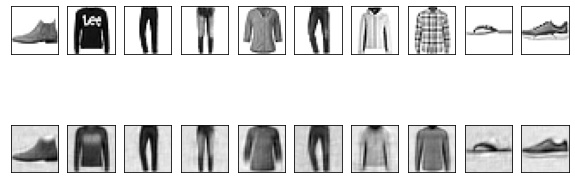

100%|██████████| 15/15 [01:50<00:00,  7.36s/it]


In [12]:
# real_array=[]
# gen_array=[]

for Epoch in tqdm(range(1, EPOCHS + 1)):
  print()
  train(model, train_loader, optimizer, log_interval=200)
  test_loss, real_image, gen_image = evaluate(model, test_loader)
  print('\n[EPOCH : {}], \t Test Loss : {:.4f}'.format(Epoch, test_loss))
  # real_array.append(real_image)
  # gen_array.append(gen_array)
  f, a = plt.subplots(2, 10, figsize=(10,4))
  for i in range(10):
    img = np.reshape(real_image[0][i], (28, 28))
    a[0][i].imshow(img, cmap='gray_r')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())

  for i in range(10):
    img = np.reshape(gen_image[0][i], (28,28))
    a[1][i].imshow(img, cmap='gray_r')
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
  plt.show()

In [13]:
  # f, a = plt.subplots(2, 10, figsize=(10,4))
  # for i in range(10):
  #   img = np.reshape(real_image[0][i], (28, 28))
  #   a[0][i].imshow(img, cmap='gray_r')
  #   a[0][i].set_xticks(())
  #   a[0][i].set_yticks(())

  # for i in range(10):
  #   img = np.reshape(gen_image[0][i], (28,28))
  #   a[1][i].imshow(img, cmap='gray_r')
  #   a[1][i].set_xticks(())
  #   a[1][i].set_yticks(())
  # plt.show()

In [14]:
# plt.imshow(np.reshape(real_array[0][0][0], (28, 28)), cmap='gray_r')

In [15]:
# f, a = plt.subplots(2, 10, figsize=(10,4))
# for idx in tqdm(range(30)):
#   for i in range(10):
#     img = np.reshape(real_array[idx][0][i], (28, 28))
#     a[0][i].imshow(img, cmap='gray_r')
#     a[0][i].set_xticks(())
#     a[0][i].set_yticks(())

#   for i in range(10):
#     img = np.reshape(gen_array[idx][0][i], (28,28))
#     a[1][i].imshow(img, cmap='gray_r')
#     a[1][i].set_xticks(())
#     a[1][i].set_yticks(())
#   plt.show()